In [1]:
#from sirf.Gadgetron import AcquisitionData, CoilSensitivityData, AcquisitionModel, ImageData
import numpy as np
import sys
sys.path.append("/Users/fatimaantarouba/Desktop/Studium/Mathematik/Doktor/Programs/Git-Repo/Hackaton/P1-Temp-Reg/modelbased-approach/")
import numpybased_auxiliary as aux
from scipy.sparse.linalg import bicgstab
from scipy.sparse.linalg import LinearOperator
from multiprocessing import Process, Pipe

In [439]:
DIR = "/Users/fatimaantarouba/Desktop/Studium/Mathematik/Doktor/Programs/Git-Repo/Hackaton/Output"
dat = np.load("{}/data_as_matrices.npz".format(DIR))
y_true = dat["y"]
noise = np.random.normal(0,100, y_true.shape)
y = np.real(y_true)+noise +(np.imag(y_true)+noise)*1j
mask = dat["mask"]
A = aux.A(mask)
u = np.zeros(y.shape, dtype=y.dtype)

In [174]:
class LHS():
    def __init__(self, template_shape, beta_x, beta_t,A,Dx,Dt):
        self.template_shape = template_shape
        self.beta_x = beta_x
        self.beta_t = beta_t
        self.A = A
        self.Dx = Dx
        self.Dt = Dt
    
    def forward(self,u):
        b = np.reshape(u,self.template_shape)
        return self.Left_hand_side(b)
        
    def Left_hand_side(self, u):

        first_part = self.A.backward(self.A.forward(u))
        second_part = self.beta_t*self.Dt.backward(self.Dt.forward(u))
        third_part = self.beta_x * self.Dx.backward(self.Dx.forward(u))
        return (first_part + second_part + third_part+0.02*u).flatten()

    def backward(self, u):
        b = np.reshape(u,self.template_shape)
        return self.back_Left_hand_side(b)
    
    def back_Left_hand_side(self, u):

        first_part = self.A.forward(self.A.backward(u))
        second_part = self.beta_t*self.Dt.forward(self.Dt.backward(u))
        third_part = self.beta_x * self.Dx.forward(self.Dx.backward(u))
        return (first_part + second_part + third_part).flatten() #+0.02*u

def Right_hand_side(y,mu_x, mu_t, z_x, z_t, beta_x,beta_t, A,Dx,Dt):
    return (A.backward(y) - Dx.backward(mu_x)- Dt.backward(mu_t)
            + beta_t*Dt.backward(z_t) + beta_x*Dx.backward(z_x))
def compute_init_u(y,A):
    return A.backward(y)

In [360]:
def solve_u_step(u_k,zt_k,zx_k,beta_x,beta_t,mut_k,mux_k, y,A,Dx,Dt):
    lhs = LHS(u_k.shape, beta_x, beta_t,A,Dx,Dt)
    operator_shape= (u_k.size, u_k.size)
    RHS = Right_hand_side(y,mux_k, mut_k, zx_k, zt_k,beta_x,beta_t, A,Dx,Dt)
    Operator = LinearOperator(operator_shape, matvec=lhs.forward )
    #u_next = bicgstab(Operator, RHS.flatten(), u_k.flatten())
    u_next=conjgrad(Operator, RHS.flatten(), u_k.flatten())
    return u_next[0].reshape(u_k.shape)

def solve_z_step(u_k, beta_t, beta_x, mut_k, mux_k, alpha, beta, A, Dx, Dt):  
    
    tmp = Dx.forward(u_k)
    tmp = (mux_k[0] + tmp[0], mux_k[1] + tmp[1])
    zkx = prox_complexed_valued_image(beta,beta_x, tmp)    
    tmp = mut_k + Dt.forward(u_k)
    zkt = prox_complexed_valued_image(alpha,beta_t, tmp)[0]
    return zkx, zkt

#def prox(alpha,x):
#    prox_output = x
#    prox_output = np.sign(x)*np.max(np.abs(x) -  alpha,0)
#    return prox_output

def prox_complexed_valued_image(alpha,gamma, z):
    inner_norm_z=0
    for z_i in z:
        shape = z_i.shape
        inner_norm_z += z_i.real**2 + z_i.imag**2 #np.sum(np.conj(z_i)*z_i)
        #z_i.real**2 + z_i.imag**2 
    norm_z = np.sqrt(inner_norm_z)
    tmp =np.maximum(np.ones(shape)-alpha/(2*gamma*norm_z), 0)
    output = [z_i*tmp for z_i in z]
    return tuple(output)
    
def component_wise_norm_cv(x):
    return np.sqrt(x.real**2 + x.imag**2)

def norm_cv(x):
    return np.sqrt(np.sum(x.real**2 + x.imag**2))

def conjgrad(A, b, x):
    r = b - A(x)
    p = r;
    rsold = np.sum(np.conj(r)*r)
    k=0
    while i<10 and rest> tolerance:
        Ap = A(p)
        alpha = rsold / np.sum(np.conj(p)*Ap)
        x = x + np.sum(alpha*p)
        r = r - np.sum(alpha*Ap)
        rsnew = np.sum(r*r)
        print(k, norm_cv(rsnew))
        if np.sqrt(rsnew) < 1e-4:
             return x
        p = r + np.dot(rsnew/rsold, p)
        rsold = rsnew
        k +=1
    return x

In [301]:
from tqdm import tqdm
u_k = compute_init_u(y,A)
Dx = aux.Dx()
Dt = aux.Dt()
zt_k = Dt.forward(u_k)
zx_k = Dx.forward(u_k)
beta_x = 0.1
beta_t = 0.1
zt_k[:] = 0
zx_k[0][:] = 0
zx_k[1][:] = 0

mut_k = zt_k
mut_k[:] = 0
mux_k = (mut_k, mut_k)


#https://aquaulb.github.io/book_solving_pde_mooc/solving_pde_mooc/notebooks/05_IterativeMethods/05_02_Conjugate_Gradient.html
def conj_g(u_k,zt_k,zx_k,beta_t,beta_x,mut_k,mux_k, y,A,Dx,Dt):
   
    b=Right_hand_side(y,mux_k, mut_k, zx_k, zt_k,beta_x,beta_t, A,Dx,Dt).flatten()
    lhs = LHS(u_k.shape, beta_x, beta_t,A,Dx,Dt)

    # Initial guess
    p0 = np.zeros(b.shape, dtype=np.complex_)#, dtype=np.complex_)

    # Place holders for the residual r and A(d)
    r = np.zeros(b.shape, dtype=np.complex_)#, dtype=np.complex_)
    Ad = np.zeros(b.shape, dtype=np.complex_)#, dtype=np.complex_)

    tolerance = 1e-5 #1e-20
    max_it = 500


    pbar = tqdm(total=max_it)
    pbar.set_description("iter / max_it");

    it = 0 # iteration counter
    diff = 1.0
    tol_hist_jac = []

    p = p0.copy()

    # Initial residual r0 and initial search direction d0
    r = -b - lhs.forward(p)
    d = r.copy()

    while (diff > tolerance):
        if it > max_it:
            print('\nSolution did not converged within the maximum'
                  ' number of iterations'
                  f'\nLast l2_diff was: {diff:.5e}')
            break

        # Laplacian of the search direction.
        Ad = lhs.forward(d)
        # Magnitude of jump.
        alpha = np.sum(np.conj(r)*r) / np.sum(np.conj(d)*Ad)
        # Iterated solution
        pnew = p + alpha*d
        # Intermediate computation
        beta_denom = np.sum(np.conj(r)*r)
        # Update the residual.
        r = r - alpha*Ad
        # Compute beta
        beta = np.sum(r*r) / beta_denom
        # Update the search direction.
        d = r + beta*d

        diff =norm_cv(r) #l2_diff(pnew, p)
        #print(diff)
        tol_hist_jac.append(diff)

        # Get ready for next iteration
        it += 1
        np.copyto(p, pnew)
        # We update our progress bar
        pbar.update(1)

    else:
        print(f'\nThe solution converged after {it} iterations')
    print(diff)
    # When the progress bar will not be used
    # further, it has to be closed
    del(pbar)
    return p.reshape(u_k.shape)

In [302]:
beta_1 = 0.1
beta_2 = 0.1

import time
tstart = time.time()
p = conj_g(u,zt_k,zx_k,beta_t,beta_x,mut_k,mux_k, y,A,Dx,Dt)
#result = solve_u_step(u_k,zt_k,zx_k,beta_1,beta_2,mut_k,mux_k, y,A,Dx,Dt)
result=p
print(time.time()-tstart)
print(norm_cv(A.forward(p)-y_true), norm_cv(A.forward(p)-y))

iter / max_it:  51%|█████████████▏            | 253/500 [00:03<00:03, 65.87it/s]


The solution converged after 259 iterations
9.082266702177774e-06
3.577670097351074
115521.07215963621 121103.05435604855


iter / max_it:  52%|█████████████▍            | 259/500 [00:03<00:03, 72.59it/s]


(128, 128, 12)
1219.2674108449476


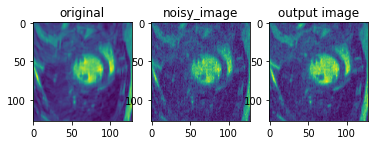

In [303]:
print(p.shape)
resimg = np.reshape(result, (128,128,12))
import matplotlib.pyplot as plt

plotframe = 6
f,ax = plt.subplots(1,3)
ax[0].imshow(np.abs(np.squeeze(A.backward(y_true)[:,:,plotframe])))
ax[0].set_title('original')
ax[1].imshow(np.abs(np.squeeze(A.backward(y)[:,:,plotframe])))
ax[1].set_title('noisy_image')
ax[2].imshow(np.abs(np.squeeze(result[:,:,plotframe])))
ax[2].set_title('output image')

In [424]:
from tqdm import tqdm
def alternative_lagrange_multiplier(max_iter):
    A = aux.A(mask)
    
    u_k = u#compute_init_u(y,A)
    Dx = aux.Dx()
    Dt = aux.Dt()
    zt_k = Dt.forward(u_k)
    zx_k = Dx.forward(u_k)

    zt_k[:] = 0
    zx_k[0][:] = 0
    zx_k[1][:] = 0

    mut_k = zt_k
    mut_k[:] = 0
    mux_k = (mut_k, mut_k)
    mut_k = zt_k.copy()
    mut_k.fill(1.0)
    
    alpha = np.random.normal(0.5,0.001,u_k.shape)#0.1*np.ones(u_k.shape)
    beta =  np.random.normal(0,0.1,u_k.shape)#0.1*np.ones(u_k.shape)
    
    beta_t = 5 #2.0
    beta_x = 5
    
    for i in tqdm(range(max_iter)):
        time_start = time.time()
        u_k = conj_g(u_k,zt_k,zx_k,beta_t,beta_x,mut_k,mux_k, y,A,Dx,Dt)
        print(norm_cv(A.forward(u_k)-y_true), norm_cv(A.forward(u_k)-y))
        zx_k, zk_t = solve_z_step(u_k, beta_t, beta_x, mut_k, mux_k, alpha, beta, A, Dx, Dt)
        mut_k +=Dt.forward(u_k)-zt_k #beta_t*() #
        tmp1 =mux_k[0] +Dx.forward(u_k)[0]-zx_k[0]
        tmp2 = mux_k[1]+Dx.forward(u_k)[1]-zx_k[1]#beta_x*() #+  
        mux_k = (tmp1, tmp2)
    
    return u_k

  0%|                                                     | 0/2 [00:00<?, ?it/s]


The solution converged after 320 iterations
9.888410121396634e-06
111471.64088409462 128439.19613630555



 50%|██████████████████████▌                      | 1/2 [00:04<00:04,  4.78s/it]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

iter / max_it:   0%|                                    | 0/500 [00:00<?, ?it/s]


The solution converged after 320 iterations
9.888410121396634e-06
111471.64088409462 128439.19613630555




iter / max_it:   2%|▍                           | 8/500 [00:00<00:06, 72.34it/s]

iter / max_it:   3%|▉                          | 17/500 [00:00<00:06, 79.46it/s]

iter / max_it:   5%|█▎                         | 25/500 [00:00<00:06, 79.16it/s]

iter / max_it:   7%|█▊                         | 34/500 [00:00<00:05, 79.64it/s]

iter / max_it:   9%|██▎                        | 43/500 [00:00<00:05, 80.74it/s]

iter / max_it:  10%|██▊                        | 52/500 [00:00<00:05, 81.01it/s]

iter / max_it:  12%|███▎                       | 61/500 [00:00<00:05, 81.78it/s]

iter / max_it:  14%|███▊                       | 70/500 [00:00<00:05, 82.82it/s]

iter / max_it:  16%|████▎                      | 79/500 [00:00<00:05, 83.45it/s]

iter / max_it:  18%|████▊                      | 88/500 [00:01<00:05, 79.35it/s]

iter / max_it:  19%|█████▏                     | 96/500 [00:01<00:05, 76.24it/s]

iter / max_it:  21%|█████▍                    | 104/500 [00:01<00:05, 73.99it/s]

iter / max_it:


The solution converged after 314 iterations
9.652702425862555e-06
109996.01003081498 126954.5471066921



 33%|███████████████                              | 1/3 [00:04<00:08,  4.15s/it]

iter / max_it:  64%|████████████████▋         | 320/500 [00:04<00:02, 77.02it/s]


iter / max_it:   0%|                                    | 0/500 [00:00<?, ?it/s]




The solution converged after 320 iterations
9.888410121396634e-06
111471.64088409462 128439.19613630555


iter / max_it:   2%|▍                           | 8/500 [00:00<00:06, 75.53it/s]

iter / max_it:   3%|▉                          | 17/500 [00:00<00:06, 79.75it/s]

iter / max_it:   5%|█▎                         | 25/500 [00:00<00:05, 79.67it/s]

iter / max_it:   7%|█▊                         | 33/500 [00:00<00:05, 79.52it/s]

iter / max_it:   8%|██▎                        | 42/500 [00:00<00:05, 79.70it/s]

iter / max_it:  10%|██▊                        | 51/500 [00:00<00:05, 80.50it/s]

iter / max_it:  12%|███▏                       | 60/500 [00:00<00:05, 81.72it/s]

iter / max_it:  14%|███▋                       | 69/500 [00:00<00:05, 82.47it/s]

iter / max_it:  16%|████▏                      | 78/500 [00:00<00:05, 83.05it/s]

iter / max_it:  17%|████▋                      | 87/500 [00:01<00:04, 83.36it/s]

iter / max_it:  19%|█████▏                     | 96/500 [00:01<00:04, 83.51it/s]

iter / max_it:  21%|█████▍                    | 105/500 [00:01<00:04, 83.82it/s]

iter / max_it:  


The solution converged after 314 iterations
9.568226932382081e-06
109996.01016157582 126954.54865649882



iter / max_it:   0%|                                    | 0/500 [00:00<?, ?it/s]


The solution converged after 318 iterations
9.326144134694199e-06
110477.25717649222 127546.31319835065



 25%|███████████▎                                 | 1/4 [00:04<00:12,  4.21s/it]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

iter / max_it:   0%|                                    | 0/500 [00:00<?, ?it/s]


The solution converged after 320 iterations
9.888410121396634e-06
111471.64088409462 128439.19613630555




iter / max_it:   1%|▎                           | 6/500 [00:00<00:08, 55.11it/s]

iter / max_it:   3%|▋                          | 13/500 [00:00<00:07, 61.16it/s]

iter / max_it:   4%|█                          | 20/500 [00:00<00:08, 59.10it/s]

iter / max_it:   5%|█▍                         | 27/500 [00:00<00:07, 59.56it/s]

iter / max_it:   7%|█▊                         | 34/500 [00:00<00:07, 62.62it/s]

iter / max_it:   8%|██▎                        | 42/500 [00:00<00:07, 65.29it/s]

iter / max_it:  10%|██▋                        | 50/500 [00:00<00:06, 68.66it/s]

iter / max_it:  12%|███▏                       | 58/500 [00:00<00:06, 71.89it/s]

iter / max_it:  13%|███▌                       | 66/500 [00:00<00:05, 73.93it/s]

iter / max_it:  15%|███▉                       | 74/500 [00:01<00:05, 74.52it/s]

iter / max_it:  16%|████▍                      | 82/500 [00:01<00:05, 75.77it/s]

iter / max_it:  18%|████▊                      | 90/500 [00:01<00:05, 76.71it/s]

iter / max_it:


The solution converged after 314 iterations
9.685801470795074e-06
109996.01660318632 126954.55255971935





iter / max_it:   2%|▍                           | 8/500 [00:00<00:06, 72.39it/s]


iter / max_it:   3%|▉                          | 17/500 [00:00<00:06, 78.57it/s]


iter / max_it:   5%|█▍                         | 26/500 [00:00<00:05, 81.84it/s]


iter / max_it:   7%|█▉                         | 35/500 [00:00<00:05, 82.51it/s]


iter / max_it:   9%|██▍                        | 44/500 [00:00<00:05, 81.85it/s]


iter / max_it:  11%|██▊                        | 53/500 [00:00<00:06, 73.84it/s]


iter / max_it:  12%|███▎                       | 61/500 [00:00<00:06, 69.25it/s]


iter / max_it:  14%|███▋                       | 69/500 [00:00<00:06, 71.11it/s]


iter / max_it:  15%|████▏                      | 77/500 [00:01<00:06, 69.29it/s]


iter / max_it:  17%|████▋                      | 86/500 [00:01<00:05, 72.55it/s]


iter / max_it:  19%|█████                      | 94/500 [00:01<00:05, 74.45it/s]


iter / max_it:  20%|█████▎                    | 102/500 [00:01<00:05, 75.30it/s]


i


The solution converged after 318 iterations
9.292384178927701e-06
110477.25847153933 127546.31557625941






iter / max_it:   1%|▍                           | 7/500 [00:00<00:07, 68.99it/s]



iter / max_it:   3%|▊                          | 16/500 [00:00<00:06, 76.48it/s]



iter / max_it:   5%|█▎                         | 25/500 [00:00<00:06, 78.81it/s]



iter / max_it:   7%|█▊                         | 34/500 [00:00<00:05, 79.81it/s]



iter / max_it:   9%|██▎                        | 43/500 [00:00<00:05, 80.88it/s]



iter / max_it:  10%|██▊                        | 52/500 [00:00<00:05, 81.07it/s]



iter / max_it:  12%|███▎                       | 61/500 [00:00<00:05, 81.79it/s]



iter / max_it:  14%|███▊                       | 70/500 [00:00<00:05, 78.70it/s]



iter / max_it:  16%|████▏                      | 78/500 [00:00<00:05, 78.84it/s]



iter / max_it:  17%|████▋                      | 87/500 [00:01<00:05, 79.00it/s]



iter / max_it:  19%|█████▏                     | 95/500 [00:01<00:05, 76.17it/s]



iter / max_it:  21%|█████▎                    | 103/500 [00:01<00:05, 74


The solution converged after 316 iterations
9.475764828943232e-06
110256.05236068879 127268.27191497615



 20%|█████████                                    | 1/5 [00:04<00:16,  4.22s/it]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

iter / max_it:   0%|                                    | 0/500 [00:00<?, ?it/s]


The solution converged after 320 iterations
9.888410121396634e-06
111471.64088409462 128439.19613630555




iter / max_it:   2%|▍                           | 8/500 [00:00<00:06, 76.08it/s]

iter / max_it:   3%|▉                          | 17/500 [00:00<00:06, 79.53it/s]

iter / max_it:   5%|█▍                         | 26/500 [00:00<00:05, 80.01it/s]

iter / max_it:   7%|█▊                         | 34/500 [00:00<00:05, 79.78it/s]

iter / max_it:   9%|██▎                        | 43/500 [00:00<00:05, 80.13it/s]

iter / max_it:  10%|██▊                        | 52/500 [00:00<00:05, 81.21it/s]

iter / max_it:  12%|███▎                       | 61/500 [00:00<00:05, 81.80it/s]

iter / max_it:  14%|███▊                       | 70/500 [00:00<00:05, 82.98it/s]

iter / max_it:  16%|████▎                      | 79/500 [00:00<00:05, 82.37it/s]

iter / max_it:  18%|████▊                      | 88/500 [00:01<00:05, 81.42it/s]

iter / max_it:  19%|█████▏                     | 97/500 [00:01<00:04, 82.25it/s]

iter / max_it:  21%|█████▌                    | 106/500 [00:01<00:04, 82.23it/s]

iter / max_it:


The solution converged after 314 iterations
9.468589074564593e-06
109996.02112562642 126954.55761140052





iter / max_it:   1%|▎                           | 6/500 [00:00<00:09, 53.68it/s]


iter / max_it:   3%|▋                          | 13/500 [00:00<00:08, 59.94it/s]


iter / max_it:   4%|█▏                         | 21/500 [00:00<00:07, 66.72it/s]


iter / max_it:   6%|█▌                         | 29/500 [00:00<00:06, 68.55it/s]


iter / max_it:   7%|█▉                         | 36/500 [00:00<00:06, 68.56it/s]


iter / max_it:   9%|██▎                        | 43/500 [00:00<00:06, 67.57it/s]


iter / max_it:  10%|██▊                        | 51/500 [00:00<00:06, 69.18it/s]


iter / max_it:  12%|███▏                       | 58/500 [00:00<00:06, 66.96it/s]


iter / max_it:  13%|███▌                       | 66/500 [00:00<00:06, 70.54it/s]


iter / max_it:  15%|███▉                       | 74/500 [00:01<00:05, 72.32it/s]


iter / max_it:  16%|████▍                      | 82/500 [00:01<00:05, 73.63it/s]


iter / max_it:  18%|████▊                      | 90/500 [00:01<00:05, 75.20it/s]


i


The solution converged after 318 iterations
9.329831258606367e-06
110477.25627991225 127546.31195224985






iter / max_it:   1%|▍                           | 7/500 [00:00<00:07, 68.90it/s]



iter / max_it:   3%|▊                          | 15/500 [00:00<00:06, 73.12it/s]



iter / max_it:   5%|█▎                         | 24/500 [00:00<00:06, 79.26it/s]



iter / max_it:   6%|█▋                         | 32/500 [00:00<00:05, 78.80it/s]



iter / max_it:   8%|██▏                        | 41/500 [00:00<00:05, 79.66it/s]



iter / max_it:  10%|██▋                        | 50/500 [00:00<00:05, 79.95it/s]



iter / max_it:  12%|███▏                       | 59/500 [00:00<00:05, 80.89it/s]



iter / max_it:  14%|███▋                       | 68/500 [00:00<00:05, 83.35it/s]



iter / max_it:  15%|████▏                      | 77/500 [00:00<00:05, 81.97it/s]



iter / max_it:  17%|████▋                      | 86/500 [00:01<00:04, 83.23it/s]



iter / max_it:  19%|█████▏                     | 95/500 [00:01<00:04, 81.80it/s]



iter / max_it:  21%|█████▍                    | 104/500 [00:01<00:05, 75


The solution converged after 316 iterations
9.4494345484178e-06
110256.05444701335 127268.27658619618


iter / max_it:   2%|▍                           | 8/500 [00:00<00:06, 73.70it/s]




iter / max_it:   3%|▉                          | 17/500 [00:00<00:06, 77.46it/s]




iter / max_it:   5%|█▎                         | 25/500 [00:00<00:06, 73.08it/s]




iter / max_it:   7%|█▊                         | 34/500 [00:00<00:06, 76.88it/s]




iter / max_it:   8%|██▎                        | 42/500 [00:00<00:05, 77.74it/s]




iter / max_it:  10%|██▊                        | 51/500 [00:00<00:05, 79.50it/s]




iter / max_it:  12%|███▏                       | 60/500 [00:00<00:05, 80.25it/s]




iter / max_it:  14%|███▋                       | 69/500 [00:00<00:05, 81.27it/s]




iter / max_it:  16%|████▏                      | 78/500 [00:01<00:05, 77.34it/s]




iter / max_it:  17%|████▋                      | 86/500 [00:01<00:05, 75.32it/s]




iter / max_it:  19%|█████                      | 94/500 [00:01<00:05, 72.88it/s]




iter / max_it:  20%|█████▎                    | 102/500 [00:01<00


The solution converged after 317 iterations
9.680113902349015e-06
110419.62670699523 127528.86843307494



 17%|███████▌                                     | 1/6 [00:04<00:23,  4.67s/it]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

iter / max_it:   0%|                                    | 0/500 [00:00<?, ?it/s]


The solution converged after 320 iterations
9.888410121396634e-06
111471.64088409462 128439.19613630555




iter / max_it:   1%|▎                           | 6/500 [00:00<00:08, 57.02it/s]

iter / max_it:   3%|▋                          | 13/500 [00:00<00:07, 61.66it/s]

iter / max_it:   4%|█                          | 20/500 [00:00<00:07, 61.76it/s]

iter / max_it:   6%|█▌                         | 28/500 [00:00<00:07, 65.92it/s]

iter / max_it:   7%|█▉                         | 35/500 [00:00<00:06, 66.87it/s]

iter / max_it:   8%|██▎                        | 42/500 [00:00<00:06, 67.45it/s]

iter / max_it:  10%|██▋                        | 50/500 [00:00<00:06, 69.39it/s]

iter / max_it:  11%|███                        | 57/500 [00:00<00:06, 67.44it/s]

iter / max_it:  13%|███▍                       | 64/500 [00:00<00:06, 66.52it/s]

iter / max_it:  14%|███▊                       | 71/500 [00:01<00:06, 67.29it/s]

iter / max_it:  16%|████▏                      | 78/500 [00:01<00:06, 65.87it/s]

iter / max_it:  17%|████▋                      | 87/500 [00:01<00:05, 71.35it/s]

iter / max_it:


The solution converged after 314 iterations
9.419803390226951e-06
109996.01494234681 126954.5512447533





iter / max_it:   1%|▎                           | 6/500 [00:00<00:09, 53.60it/s]


iter / max_it:   3%|▋                          | 13/500 [00:00<00:08, 59.50it/s]


iter / max_it:   4%|█                          | 20/500 [00:00<00:07, 63.55it/s]


iter / max_it:   6%|█▌                         | 28/500 [00:00<00:06, 67.91it/s]


iter / max_it:   7%|█▉                         | 35/500 [00:00<00:06, 68.32it/s]


iter / max_it:   9%|██▎                        | 43/500 [00:00<00:06, 70.73it/s]


iter / max_it:  10%|██▊                        | 51/500 [00:00<00:06, 72.19it/s]


iter / max_it:  12%|███▏                       | 59/500 [00:00<00:05, 74.23it/s]


iter / max_it:  13%|███▌                       | 67/500 [00:00<00:05, 75.87it/s]


iter / max_it:  15%|████                       | 75/500 [00:01<00:05, 73.48it/s]


iter / max_it:  17%|████▍                      | 83/500 [00:01<00:05, 72.63it/s]


iter / max_it:  18%|████▉                      | 91/500 [00:01<00:05, 73.65it/s]


i


The solution converged after 318 iterations
9.348099909715337e-06
110477.25838209242 127546.31507394816






iter / max_it:   3%|▊                          | 14/500 [00:00<00:07, 65.93it/s]



iter / max_it:   4%|█▏                         | 22/500 [00:00<00:06, 69.54it/s]



iter / max_it:   6%|█▌                         | 29/500 [00:00<00:06, 68.64it/s]



iter / max_it:   8%|██                         | 38/500 [00:00<00:06, 75.45it/s]



iter / max_it:   9%|██▌                        | 47/500 [00:00<00:05, 80.21it/s]



iter / max_it:  11%|███                        | 56/500 [00:00<00:05, 80.37it/s]



iter / max_it:  13%|███▌                       | 65/500 [00:00<00:05, 80.46it/s]



iter / max_it:  15%|███▉                       | 74/500 [00:00<00:05, 81.04it/s]



iter / max_it:  17%|████▍                      | 83/500 [00:01<00:05, 81.13it/s]



iter / max_it:  18%|████▉                      | 92/500 [00:01<00:04, 81.92it/s]



iter / max_it:  20%|█████▎                    | 101/500 [00:01<00:04, 83.57it/s]



iter / max_it:  22%|█████▋                    | 110/500 [00:01<00:04, 84


The solution converged after 316 iterations
9.4407104521087e-06
110256.051956632 127268.27267688932



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:04,  4.28s/it]

  0%|                                                   | 0/500 [00:00<?, ?it/s]

iter / max_it:   0%|                                    | 0/500 [00:00<?, ?it/s]


The solution converged after 317 iterations
9.67539692955404e-06
110419.62771546851 127528.87113379252




iter / max_it:   2%|▍                           | 8/500 [00:00<00:06, 71.18it/s]

iter / max_it:   3%|▊                          | 16/500 [00:00<00:06, 75.84it/s]

iter / max_it:   5%|█▎                         | 24/500 [00:00<00:06, 76.34it/s]

iter / max_it:   7%|█▊                         | 33/500 [00:00<00:05, 78.76it/s]

iter / max_it:   8%|██▎                        | 42/500 [00:00<00:05, 80.39it/s]

iter / max_it:  10%|██▊                        | 51/500 [00:00<00:05, 81.23it/s]

iter / max_it:  12%|███▏                       | 60/500 [00:00<00:05, 74.17it/s]

iter / max_it:  14%|███▋                       | 68/500 [00:00<00:05, 72.00it/s]

iter / max_it:  15%|████                       | 76/500 [00:01<00:05, 70.99it/s]

iter / max_it:  17%|████▌                      | 84/500 [00:01<00:05, 71.47it/s]

iter / max_it:  18%|████▉                      | 92/500 [00:01<00:05, 73.02it/s]

iter / max_it:  20%|█████▏                    | 100/500 [00:01<00:05, 74.60it/s]

iter / max_it:


The solution converged after 317 iterations
9.236940683217769e-06
110346.81849121202 127424.20349437445


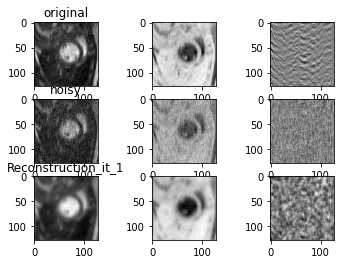

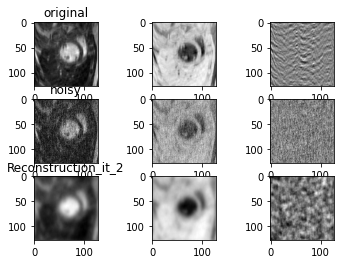

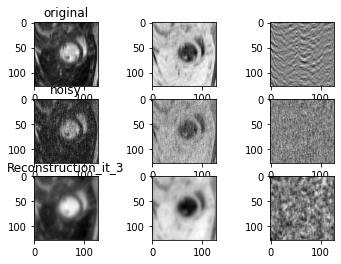

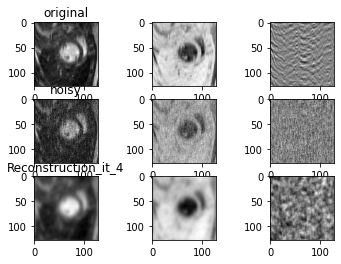

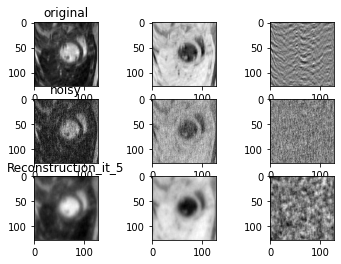

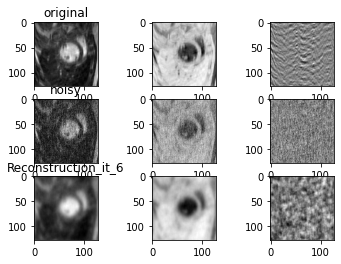

In [442]:
import matplotlib.pyplot as plt
import nibabel as nib
maxs=  range(1,7)
for maxiter in maxs:
    result = alternative_lagrange_multiplier(maxiter)
    nii = nib.Nifti1Image(np.abs(result),np.eye(4))
    nib.save(nii,"{0}/result_mi{1}.nii".format(DIR,maxiter))
    plotframe = 6
    f,ax = plt.subplots(3,3)
    
    ax[0,0].set_title('original')
    ax[0,0].imshow(np.abs(np.squeeze(-A.backward(y_true)[:,:,plotframe])),cmap='gray')
    ax[0,1].imshow(np.real(np.squeeze(-A.backward(y_true)[:,:,plotframe])),cmap='gray')#np.flip(,axis=0)#Dx.forward(u_k)[0]
    ax[0,2].imshow(np.imag(np.squeeze(A.backward(y_true)[:,:,plotframe])), cmap='gray')
    
    ax[1,0].set_title('noisy')
    ax[1,0].imshow(np.abs(np.squeeze(-A.backward(y)[:,:,plotframe])), cmap='gray')#Dx.forward(u_k)[0]
    ax[1,1].imshow(np.real(np.squeeze(-A.backward(y)[:,:,plotframe])), cmap='gray')
    ax[1,2].imshow(np.imag(np.squeeze(A.backward(y)[:,:,plotframe])), cmap='gray')

    ax[2,0].set_title('Reconstruction_it_{}'.format(maxiter))
    ax[2,0].imshow(np.abs(np.squeeze(result[:,:,plotframe])), cmap='gray')
    ax[2,1].imshow(np.real(np.squeeze(result[:,:,plotframe])), cmap='gray')
    ax[2,2].imshow(np.imag(np.squeeze(result[:,:,plotframe])), cmap='gray')